# MINI PROJECT

In [1]:
# 0. import
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import Subset, random_split
from torchvision import datasets, transforms, utils, models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from collections import defaultdict, Counter
import random, os
import pandas as pd
import copy
random.seed(43)

## 1. Baseline

In [12]:
# 1. hyperparameters
BATCH_SIZE = 64
NUM_EPOCHS = 30
DEVICE = ("mps" if torch.backends.mps.is_available() else "cpu")

### 1.1. Data

In [13]:
# 2. prepare CIFAR10 data
transform_baseline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # well-known values
])

full_trainset_baseline = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_baseline)
testset_baseline = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_baseline)

# split
seed = 42
g = torch.Generator().manual_seed(seed) # seed 고정

train_size = int(0.9 * len(full_trainset_baseline))
val_size = len(full_trainset_baseline) - train_size
trainset_baseline, valset_baseline = random_split(full_trainset_baseline, [train_size, val_size], generator=g)

# loader
train_loader_baseline = torch.utils.data.DataLoader(trainset_baseline, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_baseline = torch.utils.data.DataLoader(valset_baseline, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_baseline = torch.utils.data.DataLoader(testset_baseline, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


Files already downloaded and verified
Files already downloaded and verified


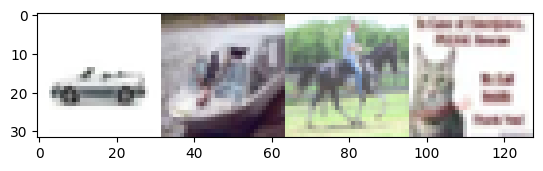

Class labels:  car   ship  horse cat  


In [14]:
# 3. show some examples
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def unnormalize(img):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    return img * std + mean

def imshow(img):
    # unnormalize
    img = unnormalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader_baseline)
images, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### 1.2. Model and Train

In [15]:
# 4. select model: resnet18

model = models.resnet18(weights=None, num_classes=10) # 10 classes
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# 5. select loss function, optimizer, and lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=NUM_EPOCHS,
    eta_min=1e-6,
)

In [17]:
# 6. define evaluation function
def eval(model, test_loader, criterion):
    model.eval()  # Set the model to the evaluation mode.
    running_loss = 0.0
    running_correct = 0.0
    running_total = 0.0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(imgs) # forward
            loss = criterion(outputs, labels)
            
            max_prob, max_idx = torch.max(outputs, 1)
            predicted = max_idx.to(DEVICE)

            running_loss += loss.item()

            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_test_loss = running_loss / len(test_loader)
    acc = 100 * running_correct / running_total
    f1 = f1_score(all_labels, all_preds, average='macro') 
    
    print(f'    loss: {avg_test_loss:.3f} acc: {acc:.2f}% f1: {f1:.2f}')

    return acc, avg_test_loss, f1

In [18]:
# 7. define train function + val list 반환?
def train(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader, to_save):
    acc_list = []
    loss_list = []
    f1_list = []
    val_acc_list = []
    val_loss_list = []
    val_f1_list = []
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0

        all_preds = []
        all_labels = []
        
        model.train()
        
        for i, (imgs, label) in tqdm(enumerate(train_loader, 0)):
            # Set the data to the correct device; Different task will use different inputs and labels
            imgs = imgs.to(DEVICE)
            labels = label.to(DEVICE)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(imgs) # forward
            loss = criterion(outputs, labels)
            loss.backward() # backward
            optimizer.step() # optimize

            # Get predicted results
            max_prob, max_idx = torch.max(outputs, 1)
            predicted = max_idx.to(DEVICE)

            # print statistics
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            # F1 계산용
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        scheduler.step() # scheduler
        # print loss and acc
        avg_loss = running_loss / len(train_loader)
        acc = 100 * running_correct / running_total
        f1 = f1_score(all_labels, all_preds, average='macro') 
        
        print(f'[{epoch + 1}] loss: {avg_loss:.3f} acc: {acc:.2f}% f1: {f1:.2f}')
        print(f'    learning rate was {scheduler.get_last_lr()[0]:.5f}')

        loss_list.append(avg_loss)
        acc_list.append(acc)
        f1_list.append(f1)
        
        # validation per 10 epochs & save model
        
        print(f'>> Validation')
        val_acc, val_loss, val_f1 = eval(model, val_loader, criterion)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)
        val_f1_list.append(val_f1)
        
        if epoch % 3 == 2: # 3 epoch 마다 저장
            torch.save(model.state_dict(), f'./model/{to_save}/epoch{epoch+1}.pth')
            
    print('Finished Training')
    # save final model
    torch.save(model.state_dict(), f'./model/1_baseline/final.pth')
    
    return loss_list, acc_list, f1_list, val_loss_list, val_acc_list, val_f1_list

In [19]:
# 8. train
loss_list, acc_list, f1_list, val_loss_list, val_acc_list, val_f1_list = train(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, train_loader=train_loader_baseline, val_loader=val_loader_baseline, to_save="1_baseline")

704it [00:21, 32.37it/s]


[1] loss: 1.402 acc: 50.07% f1: 0.50
    learning rate was 0.00100
>> Validation
    loss: 1.229 acc: 56.48% f1: 0.55


704it [00:21, 32.79it/s]


[2] loss: 1.011 acc: 64.40% f1: 0.64
    learning rate was 0.00099
>> Validation
    loss: 1.014 acc: 63.98% f1: 0.64


704it [00:23, 30.22it/s]


[3] loss: 0.845 acc: 70.46% f1: 0.70
    learning rate was 0.00098
>> Validation
    loss: 0.868 acc: 69.18% f1: 0.69


704it [00:31, 22.08it/s]


[4] loss: 0.711 acc: 75.37% f1: 0.75
    learning rate was 0.00096
>> Validation
    loss: 0.828 acc: 71.02% f1: 0.71


704it [00:31, 22.02it/s]


[5] loss: 0.604 acc: 78.89% f1: 0.79
    learning rate was 0.00093
>> Validation
    loss: 0.757 acc: 74.16% f1: 0.74


704it [00:31, 22.09it/s]


[6] loss: 0.496 acc: 82.71% f1: 0.83
    learning rate was 0.00090
>> Validation
    loss: 0.770 acc: 73.66% f1: 0.74


704it [00:31, 22.66it/s]


[7] loss: 0.402 acc: 86.09% f1: 0.86
    learning rate was 0.00087
>> Validation
    loss: 0.743 acc: 75.12% f1: 0.75


704it [00:31, 22.45it/s]


[8] loss: 0.326 acc: 88.46% f1: 0.88
    learning rate was 0.00083
>> Validation
    loss: 0.811 acc: 75.06% f1: 0.75


704it [00:31, 22.21it/s]


[9] loss: 0.257 acc: 90.92% f1: 0.91
    learning rate was 0.00079
>> Validation
    loss: 0.786 acc: 76.96% f1: 0.77


704it [00:32, 21.93it/s]


[10] loss: 0.185 acc: 93.50% f1: 0.93
    learning rate was 0.00075
>> Validation
    loss: 0.861 acc: 75.70% f1: 0.76


704it [00:31, 22.08it/s]


[11] loss: 0.151 acc: 94.75% f1: 0.95
    learning rate was 0.00070
>> Validation
    loss: 0.901 acc: 76.36% f1: 0.76


704it [00:30, 22.87it/s]


[12] loss: 0.131 acc: 95.43% f1: 0.95
    learning rate was 0.00065
>> Validation
    loss: 0.989 acc: 76.78% f1: 0.77


704it [00:30, 22.75it/s]


[13] loss: 0.079 acc: 97.33% f1: 0.97
    learning rate was 0.00060
>> Validation
    loss: 1.109 acc: 75.58% f1: 0.76


704it [00:31, 22.45it/s]


[14] loss: 0.072 acc: 97.46% f1: 0.97
    learning rate was 0.00055
>> Validation
    loss: 1.141 acc: 75.04% f1: 0.75


704it [00:31, 22.56it/s]


[15] loss: 0.063 acc: 97.81% f1: 0.98
    learning rate was 0.00050
>> Validation
    loss: 1.088 acc: 76.88% f1: 0.77


704it [00:30, 22.84it/s]


[16] loss: 0.035 acc: 98.84% f1: 0.99
    learning rate was 0.00045
>> Validation
    loss: 1.254 acc: 76.24% f1: 0.76


704it [00:31, 22.70it/s]


[17] loss: 0.034 acc: 98.89% f1: 0.99
    learning rate was 0.00040
>> Validation
    loss: 1.261 acc: 76.54% f1: 0.76


704it [00:31, 22.43it/s]


[18] loss: 0.028 acc: 99.04% f1: 0.99
    learning rate was 0.00035
>> Validation
    loss: 1.282 acc: 77.18% f1: 0.77


704it [00:31, 22.24it/s]


[19] loss: 0.014 acc: 99.53% f1: 1.00
    learning rate was 0.00030
>> Validation
    loss: 1.300 acc: 77.10% f1: 0.77


704it [00:31, 22.62it/s]


[20] loss: 0.016 acc: 99.44% f1: 0.99
    learning rate was 0.00025
>> Validation
    loss: 1.377 acc: 76.86% f1: 0.77


704it [00:31, 22.34it/s]


[21] loss: 0.013 acc: 99.59% f1: 1.00
    learning rate was 0.00021
>> Validation
    loss: 1.388 acc: 76.82% f1: 0.77


704it [00:31, 22.49it/s]


[22] loss: 0.008 acc: 99.76% f1: 1.00
    learning rate was 0.00017
>> Validation
    loss: 1.394 acc: 77.80% f1: 0.78


704it [00:30, 22.99it/s]


[23] loss: 0.003 acc: 99.94% f1: 1.00
    learning rate was 0.00013
>> Validation
    loss: 1.404 acc: 78.56% f1: 0.78


704it [00:31, 22.25it/s]


[24] loss: 0.002 acc: 99.95% f1: 1.00
    learning rate was 0.00010
>> Validation
    loss: 1.407 acc: 78.16% f1: 0.78


704it [00:31, 22.43it/s]


[25] loss: 0.001 acc: 99.98% f1: 1.00
    learning rate was 0.00007
>> Validation
    loss: 1.423 acc: 78.48% f1: 0.78


704it [00:31, 22.14it/s]


[26] loss: 0.001 acc: 100.00% f1: 1.00
    learning rate was 0.00004
>> Validation
    loss: 1.434 acc: 78.54% f1: 0.78


704it [00:31, 22.32it/s]


[27] loss: 0.002 acc: 99.98% f1: 1.00
    learning rate was 0.00003
>> Validation
    loss: 1.456 acc: 78.66% f1: 0.78


704it [00:31, 22.56it/s]


[28] loss: 0.001 acc: 99.98% f1: 1.00
    learning rate was 0.00001
>> Validation
    loss: 1.448 acc: 77.84% f1: 0.78


704it [00:31, 22.10it/s]


[29] loss: 0.001 acc: 99.99% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 1.439 acc: 78.64% f1: 0.78


704it [00:31, 22.01it/s]


[30] loss: 0.001 acc: 99.99% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 1.431 acc: 78.50% f1: 0.78
Finished Training


### 1.3. Test and Visualization

In [20]:
# 9. function for visualization
def graph(train_list, val_list, type, n_epochs): # type = ["Loss", "Accuracy", "F1"]
    plt.plot(range(1, n_epochs+1), train_list, label=f"Train {type}", color='blue')
    plt.plot(range(1, n_epochs+1), val_list, label=f"Validation {type}", color='green')
    plt.xlabel('Epochs')
    plt.ylabel(f'{type}')
    plt.title(f'Training and Validation {type}')
    plt.legend()
    plt.show()

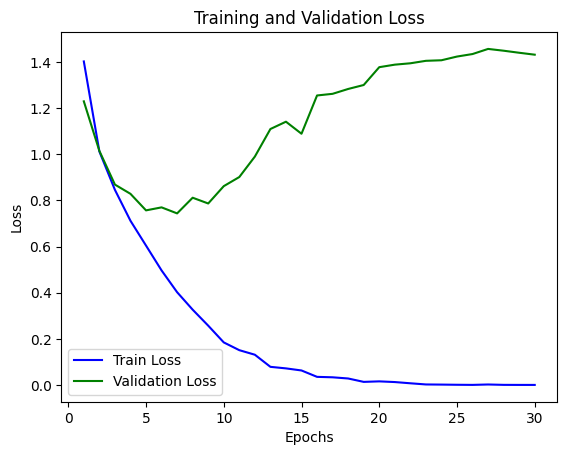

In [21]:
graph(loss_list, val_loss_list, "Loss", NUM_EPOCHS)

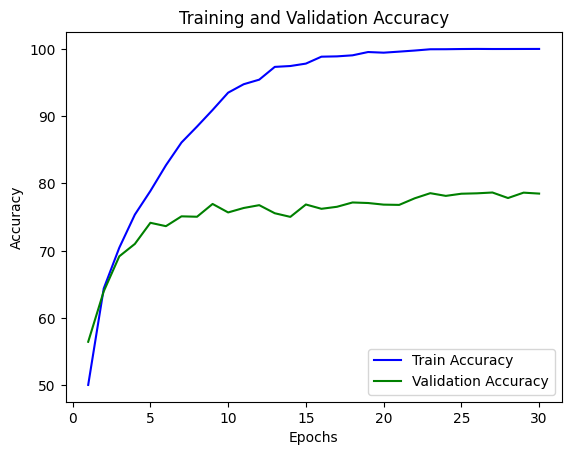

In [23]:
graph(acc_list, val_acc_list, "Accuracy", NUM_EPOCHS)

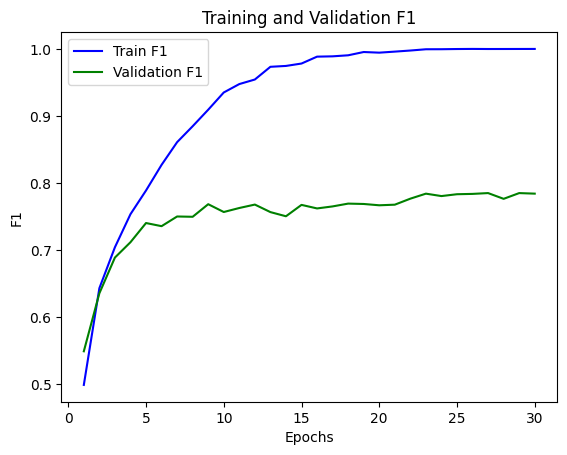

In [24]:
graph(f1_list, val_f1_list, "F1", NUM_EPOCHS)

In [25]:
def choose_best_val(lst):
    indices = [i for i in range(len(lst)) if i % 3 == 2]
    min_index = min(indices, key=lambda i: lst[i])
    print("Min Val:", lst[min_index])
    return min_index

In [26]:
min_idx = choose_best_val(val_loss_list)
print("Best model at epoch", min_idx+1)

Min Val: 0.7695223828659782
Best model at epoch 6


In [27]:
# 10. test with best model w/ min loss

best_model = models.resnet18(weights=None)
best_model.fc = nn.Linear(model.fc.in_features, 10) # 10 classes
best_model.to(DEVICE)
best_model.load_state_dict(torch.load(f'./model/1_baseline/epoch{min_idx+1}.pth'))
torch.save(best_model.state_dict(), f'./model/best_models/1_epoch{min_idx+1}.pth') # save best model

test_acc, test_loss, test_f1 = eval(best_model, test_loader=test_loader_baseline, criterion=criterion)

    loss: 0.798 acc: 73.77% f1: 0.74


## 2. Variants

### 2.1. Random Label Shuffle
학습 데이터의 라벨을 완전히 무작위로 섞어서 학습

#### 1) Data

In [52]:
# 1. prepare new CIFAR10 train data(randomly shuffle labels)
trainset_baseline_var1 = copy.deepcopy(trainset_baseline)

subset_indices = trainset_baseline_var1.indices  # Subset 내에서 사용된 실제 인덱스
original_labels = [trainset_baseline_var1.dataset.targets[i] for i in subset_indices]

# shuffle
shuffled_labels = original_labels.copy()
random.shuffle(shuffled_labels)

for idx, new_label in zip(subset_indices, shuffled_labels):
    trainset_baseline_var1.dataset.targets[idx] = new_label

# loader
train_loader_var1 = torch.utils.data.DataLoader(trainset_baseline_var1, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


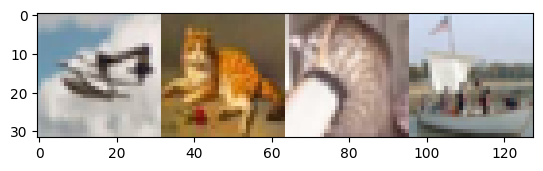

Class labels:  deer  truck car   dog  


In [53]:
dataiter = iter(train_loader_var1)
images, labels = next(dataiter)

# print images
img_grid = imshow(utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

#### 2) Model and Train

In [54]:
# 2. resnet18
model_var1 = models.resnet18(weights=None, num_classes=10) # 10 classes
model_var1.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [55]:
# 3. select loss function, optimizer, and lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_var1.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=NUM_EPOCHS,
    eta_min=1e-6,
)

In [56]:
# 4. train
loss_list_var1, acc_list_var1, f1_list_var1, val_loss_list_var1, val_acc_list_var1, val_f1_list_var1 = train(model_var1, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, train_loader=train_loader_var1, val_loader=val_loader_baseline, to_save='2-1_var1')

704it [00:21, 33.38it/s]


[1] loss: 2.362 acc: 9.98% f1: 0.10
    learning rate was 0.00100
>> Validation
    loss: 2.315 acc: 10.20% f1: 0.04


704it [00:21, 32.72it/s]


[2] loss: 2.346 acc: 10.12% f1: 0.10
    learning rate was 0.00099
>> Validation
    loss: 2.344 acc: 10.64% f1: 0.03


704it [00:21, 32.65it/s]


[3] loss: 2.339 acc: 10.00% f1: 0.10
    learning rate was 0.00098
>> Validation
    loss: 2.311 acc: 8.16% f1: 0.03


704it [00:21, 33.38it/s]


[4] loss: 2.332 acc: 10.22% f1: 0.10
    learning rate was 0.00096
>> Validation
    loss: 2.318 acc: 10.18% f1: 0.04


704it [00:23, 30.19it/s]


[5] loss: 2.328 acc: 10.28% f1: 0.10
    learning rate was 0.00093
>> Validation
    loss: 2.353 acc: 12.10% f1: 0.06


704it [00:31, 22.33it/s]


[6] loss: 2.326 acc: 10.11% f1: 0.10
    learning rate was 0.00090
>> Validation
    loss: 2.334 acc: 10.80% f1: 0.04


704it [00:31, 22.20it/s]


[7] loss: 2.320 acc: 10.06% f1: 0.09
    learning rate was 0.00087
>> Validation
    loss: 2.307 acc: 10.82% f1: 0.05


704it [00:30, 22.78it/s]


[8] loss: 2.322 acc: 9.87% f1: 0.10
    learning rate was 0.00083
>> Validation
    loss: 2.339 acc: 11.16% f1: 0.04


704it [00:31, 22.35it/s]


[9] loss: 2.318 acc: 9.90% f1: 0.09
    learning rate was 0.00079
>> Validation
    loss: 2.311 acc: 9.68% f1: 0.03


704it [00:32, 21.88it/s]


[10] loss: 2.314 acc: 10.12% f1: 0.10
    learning rate was 0.00075
>> Validation
    loss: 2.309 acc: 8.00% f1: 0.05


704it [00:32, 21.98it/s]


[11] loss: 2.314 acc: 10.03% f1: 0.09
    learning rate was 0.00070
>> Validation
    loss: 2.322 acc: 9.10% f1: 0.03


704it [00:31, 22.54it/s]


[12] loss: 2.312 acc: 9.90% f1: 0.09
    learning rate was 0.00065
>> Validation
    loss: 2.323 acc: 8.90% f1: 0.04


704it [00:31, 22.16it/s]


[13] loss: 2.312 acc: 9.84% f1: 0.09
    learning rate was 0.00060
>> Validation
    loss: 2.305 acc: 8.82% f1: 0.06


704it [00:32, 21.94it/s]


[14] loss: 2.309 acc: 9.83% f1: 0.08
    learning rate was 0.00055
>> Validation
    loss: 2.308 acc: 11.12% f1: 0.06


704it [00:32, 21.97it/s]


[15] loss: 2.308 acc: 9.95% f1: 0.09
    learning rate was 0.00050
>> Validation
    loss: 2.302 acc: 9.90% f1: 0.06


704it [00:31, 22.53it/s]


[16] loss: 2.307 acc: 10.02% f1: 0.09
    learning rate was 0.00045
>> Validation
    loss: 2.297 acc: 9.28% f1: 0.03


704it [00:31, 22.37it/s]


[17] loss: 2.307 acc: 9.91% f1: 0.09
    learning rate was 0.00040
>> Validation
    loss: 2.304 acc: 9.64% f1: 0.06


704it [00:31, 22.27it/s]


[18] loss: 2.306 acc: 10.24% f1: 0.09
    learning rate was 0.00035
>> Validation
    loss: 2.306 acc: 11.14% f1: 0.07


704it [00:30, 22.72it/s]


[19] loss: 2.305 acc: 10.27% f1: 0.10
    learning rate was 0.00030
>> Validation
    loss: 2.312 acc: 8.34% f1: 0.06


704it [00:30, 22.90it/s]


[20] loss: 2.305 acc: 10.36% f1: 0.10
    learning rate was 0.00025
>> Validation
    loss: 2.308 acc: 12.68% f1: 0.10


704it [00:30, 22.82it/s]


[21] loss: 2.304 acc: 10.30% f1: 0.09
    learning rate was 0.00021
>> Validation
    loss: 2.305 acc: 12.22% f1: 0.08


704it [00:31, 22.30it/s]


[22] loss: 2.304 acc: 10.49% f1: 0.10
    learning rate was 0.00017
>> Validation
    loss: 2.303 acc: 12.28% f1: 0.10


704it [00:30, 22.94it/s]


[23] loss: 2.304 acc: 10.40% f1: 0.09
    learning rate was 0.00013
>> Validation
    loss: 2.300 acc: 11.26% f1: 0.08


704it [00:30, 22.73it/s]


[24] loss: 2.303 acc: 10.53% f1: 0.09
    learning rate was 0.00010
>> Validation
    loss: 2.301 acc: 11.20% f1: 0.09


704it [00:31, 22.52it/s]


[25] loss: 2.302 acc: 10.78% f1: 0.10
    learning rate was 0.00007
>> Validation
    loss: 2.302 acc: 11.04% f1: 0.10


704it [00:31, 22.23it/s]


[26] loss: 2.302 acc: 10.99% f1: 0.10
    learning rate was 0.00004
>> Validation
    loss: 2.301 acc: 11.22% f1: 0.10


704it [00:31, 22.41it/s]


[27] loss: 2.301 acc: 10.99% f1: 0.10
    learning rate was 0.00003
>> Validation
    loss: 2.303 acc: 10.86% f1: 0.10


704it [00:31, 22.25it/s]


[28] loss: 2.300 acc: 11.16% f1: 0.10
    learning rate was 0.00001
>> Validation
    loss: 2.303 acc: 10.70% f1: 0.10


704it [00:31, 22.27it/s]


[29] loss: 2.300 acc: 11.14% f1: 0.10
    learning rate was 0.00000
>> Validation
    loss: 2.303 acc: 10.52% f1: 0.10


704it [00:31, 22.29it/s]


[30] loss: 2.299 acc: 11.40% f1: 0.11
    learning rate was 0.00000
>> Validation
    loss: 2.303 acc: 10.68% f1: 0.10
Finished Training


#### 3) Test and Visualization

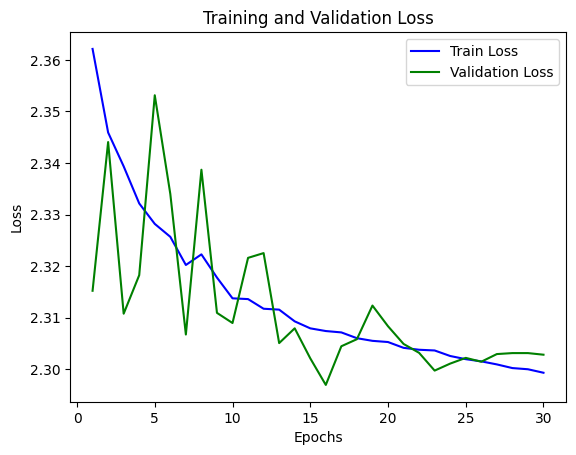

In [57]:
graph(loss_list_var1, val_loss_list_var1, "Loss", NUM_EPOCHS)

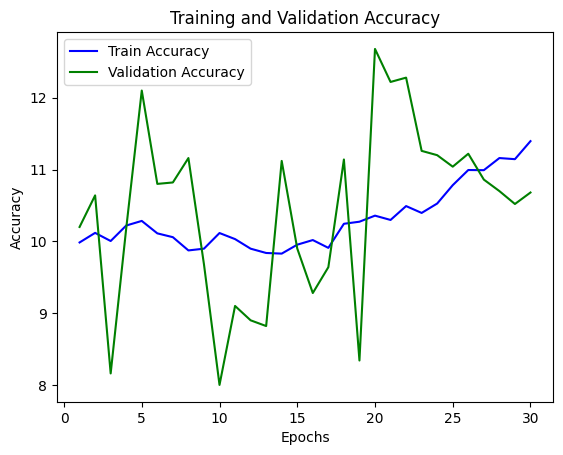

In [58]:
graph(acc_list_var1, val_acc_list_var1, "Accuracy", NUM_EPOCHS)

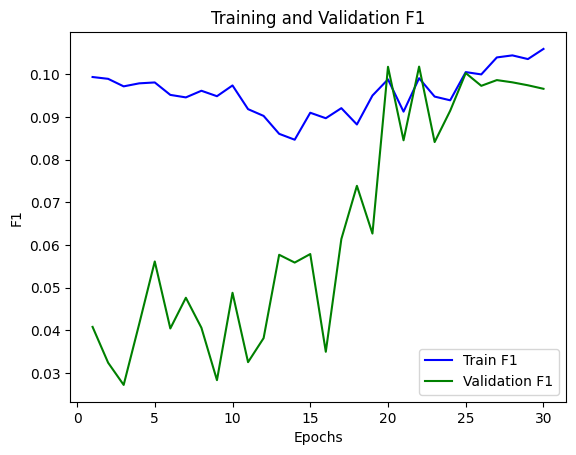

In [59]:
graph(f1_list_var1, val_f1_list_var1, "F1", NUM_EPOCHS)

In [60]:
# 5. find min loss
min_idx_var1 = choose_best_val(val_loss_list_var1)
print("Best model at epoch", min_idx_var1+1)

Min Val: 2.301072340977343
Best model at epoch 24


In [61]:
# 6. test with best model w/ min loss
best_model_var1 = models.resnet18(weights=None, num_classes=10)
best_model_var1.to(DEVICE)
best_model_var1.load_state_dict(torch.load(f'./model/2-1_var1/epoch{min_idx_var1+1}.pth'))
torch.save(best_model_var1.state_dict(), f'./model/best_models/2-1_epoch{min_idx_var1+1}.pth') # save best model

test_acc_var1, test_loss_var1, test_f1_var1 = eval(best_model_var1, test_loader=test_loader_baseline, criterion=criterion)

    loss: 2.300 acc: 11.44% f1: 0.09


### 2.2. Label Noise (20%)
학습 데이터 중 20%의 라벨을 무작위로 다른 클래스로 변경

#### 1) Data

In [62]:
# 1. prepare new CIFAR10 train data(randomly shuffle labels 20%)
trainset_baseline_var2 = copy.deepcopy(trainset_baseline)

num_classes = 10
change_ratio = 0.2

subset_indices = trainset_baseline_var2.indices  # Subset 내에서 사용된 실제 인덱스
original_labels = [trainset_baseline_var2.dataset.targets[i] for i in subset_indices]

num_to_change = int(change_ratio * len(subset_indices))
change_indices = random.sample(subset_indices, num_to_change)

# 라벨 변경
for idx in change_indices:
    current_label = trainset_baseline_var2.dataset.targets[idx]
    new_label = random.choice([i for i in range(num_classes) if i != current_label])
    trainset_baseline_var2.dataset.targets[idx] = new_label

# loader
train_loader_var2 = torch.utils.data.DataLoader(trainset_baseline_var2, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

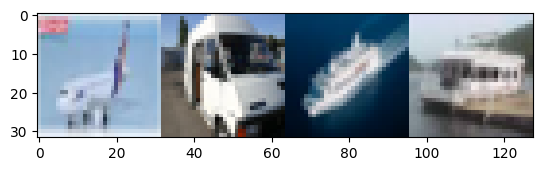

Changed labels: horse horse horse dog  
Original labels: plane truck ship  ship 


In [63]:
# 바뀐 인덱스 중 4개 예시
example_indices = change_indices[:4]

# 이미지와 라벨 추출 (transform 적용된 데이터셋 기준)
images = [trainset_baseline_var2.dataset[i][0] for i in example_indices]
labels = [trainset_baseline_var2.dataset.targets[i] for i in example_indices]
labels2 = [trainset_baseline.dataset.targets[i] for i in example_indices] # original

# Tensor로 묶기
images_tensor = torch.stack(images)

# 시각화 실행
imshow(utils.make_grid(images_tensor, padding=0))
print('Changed labels:', ' '.join(f'{classes[new]:5s}' for new in labels))
print('Original labels:', ' '.join(f'{classes[new]:5s}' for new in labels2))

#### 2) Model and Train

In [64]:
# 2. resnet18
model_var2 = models.resnet18(weights=None, num_classes=10) # 10 classes
model_var2.to(DEVICE)

# 3. select loss function, optimizer, and lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_var2.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=NUM_EPOCHS,
    eta_min=1e-6,
)

In [65]:
# 4. train
loss_list_var2, acc_list_var2, f1_list_var2, val_loss_list_var2, val_acc_list_var2, val_f1_list_var2 = train(model_var2, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, train_loader=train_loader_var2, val_loader=val_loader_baseline, to_save='2-2_var2')

704it [00:20, 33.80it/s]


[1] loss: 1.876 acc: 36.85% f1: 0.37
    learning rate was 0.00100
>> Validation
    loss: 1.471 acc: 50.10% f1: 0.49


704it [00:30, 22.72it/s]


[2] loss: 1.643 acc: 48.39% f1: 0.48
    learning rate was 0.00099
>> Validation
    loss: 1.256 acc: 59.08% f1: 0.60


704it [00:30, 22.76it/s]


[3] loss: 1.523 acc: 53.92% f1: 0.54
    learning rate was 0.00098
>> Validation
    loss: 1.158 acc: 63.22% f1: 0.62


704it [00:32, 21.87it/s]


[4] loss: 1.438 acc: 57.61% f1: 0.58
    learning rate was 0.00096
>> Validation
    loss: 1.022 acc: 68.58% f1: 0.69


704it [00:32, 21.91it/s]


[5] loss: 1.360 acc: 60.68% f1: 0.61
    learning rate was 0.00093
>> Validation
    loss: 1.043 acc: 67.60% f1: 0.67


704it [00:31, 22.57it/s]


[6] loss: 1.282 acc: 63.81% f1: 0.64
    learning rate was 0.00090
>> Validation
    loss: 0.947 acc: 69.62% f1: 0.70


704it [00:31, 22.33it/s]


[7] loss: 1.189 acc: 66.81% f1: 0.67
    learning rate was 0.00087
>> Validation
    loss: 0.934 acc: 71.02% f1: 0.71


704it [00:31, 22.32it/s]


[8] loss: 1.082 acc: 70.31% f1: 0.70
    learning rate was 0.00083
>> Validation
    loss: 0.994 acc: 69.06% f1: 0.69


704it [00:31, 22.40it/s]


[9] loss: 0.956 acc: 73.96% f1: 0.74
    learning rate was 0.00079
>> Validation
    loss: 1.009 acc: 68.46% f1: 0.68


704it [00:30, 22.72it/s]


[10] loss: 0.816 acc: 77.59% f1: 0.78
    learning rate was 0.00075
>> Validation
    loss: 1.130 acc: 67.12% f1: 0.67


704it [00:31, 22.31it/s]


[11] loss: 0.678 acc: 81.02% f1: 0.81
    learning rate was 0.00070
>> Validation
    loss: 1.315 acc: 64.06% f1: 0.64


704it [00:31, 22.17it/s]


[12] loss: 0.524 acc: 84.82% f1: 0.85
    learning rate was 0.00065
>> Validation
    loss: 1.446 acc: 64.46% f1: 0.65


704it [00:31, 22.53it/s]


[13] loss: 0.405 acc: 87.95% f1: 0.88
    learning rate was 0.00060
>> Validation
    loss: 1.476 acc: 64.72% f1: 0.64


704it [00:31, 22.33it/s]


[14] loss: 0.296 acc: 90.73% f1: 0.91
    learning rate was 0.00055
>> Validation
    loss: 1.706 acc: 63.72% f1: 0.64


704it [00:32, 22.00it/s]


[15] loss: 0.231 acc: 92.76% f1: 0.93
    learning rate was 0.00050
>> Validation
    loss: 1.879 acc: 62.66% f1: 0.63


704it [00:31, 22.13it/s]


[16] loss: 0.156 acc: 95.16% f1: 0.95
    learning rate was 0.00045
>> Validation
    loss: 2.045 acc: 61.14% f1: 0.61


704it [00:31, 22.60it/s]


[17] loss: 0.113 acc: 96.38% f1: 0.96
    learning rate was 0.00040
>> Validation
    loss: 2.179 acc: 62.48% f1: 0.62


704it [00:30, 23.18it/s]


[18] loss: 0.075 acc: 97.62% f1: 0.98
    learning rate was 0.00035
>> Validation
    loss: 2.363 acc: 61.08% f1: 0.61


704it [00:31, 22.35it/s]


[19] loss: 0.068 acc: 97.86% f1: 0.98
    learning rate was 0.00030
>> Validation
    loss: 2.335 acc: 62.46% f1: 0.63


704it [00:32, 21.97it/s]


[20] loss: 0.036 acc: 98.91% f1: 0.99
    learning rate was 0.00025
>> Validation
    loss: 2.392 acc: 62.78% f1: 0.63


704it [00:31, 22.35it/s]


[21] loss: 0.022 acc: 99.36% f1: 0.99
    learning rate was 0.00021
>> Validation
    loss: 2.518 acc: 62.64% f1: 0.62


704it [00:31, 22.05it/s]


[22] loss: 0.021 acc: 99.36% f1: 0.99
    learning rate was 0.00017
>> Validation
    loss: 2.570 acc: 63.24% f1: 0.63


704it [00:31, 22.51it/s]


[23] loss: 0.013 acc: 99.64% f1: 1.00
    learning rate was 0.00013
>> Validation
    loss: 2.698 acc: 61.64% f1: 0.61


704it [00:31, 22.42it/s]


[24] loss: 0.008 acc: 99.78% f1: 1.00
    learning rate was 0.00010
>> Validation
    loss: 2.643 acc: 63.50% f1: 0.63


704it [00:32, 21.93it/s]


[25] loss: 0.007 acc: 99.84% f1: 1.00
    learning rate was 0.00007
>> Validation
    loss: 2.642 acc: 63.86% f1: 0.64


704it [00:32, 21.95it/s]


[26] loss: 0.003 acc: 99.94% f1: 1.00
    learning rate was 0.00004
>> Validation
    loss: 2.692 acc: 64.18% f1: 0.64


704it [00:30, 23.10it/s]


[27] loss: 0.003 acc: 99.97% f1: 1.00
    learning rate was 0.00003
>> Validation
    loss: 2.679 acc: 64.62% f1: 0.64


704it [00:31, 22.50it/s]


[28] loss: 0.002 acc: 99.98% f1: 1.00
    learning rate was 0.00001
>> Validation
    loss: 2.717 acc: 64.36% f1: 0.64


704it [00:31, 22.02it/s]


[29] loss: 0.002 acc: 99.97% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 2.745 acc: 64.00% f1: 0.64


704it [00:32, 21.86it/s]


[30] loss: 0.001 acc: 99.98% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 2.756 acc: 64.18% f1: 0.64
Finished Training


#### 3) Test and Visualization

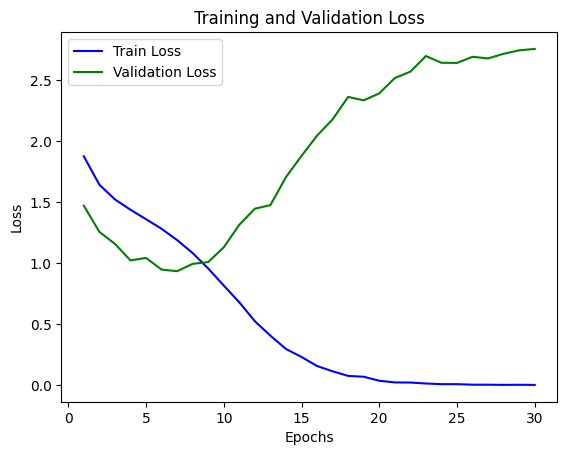

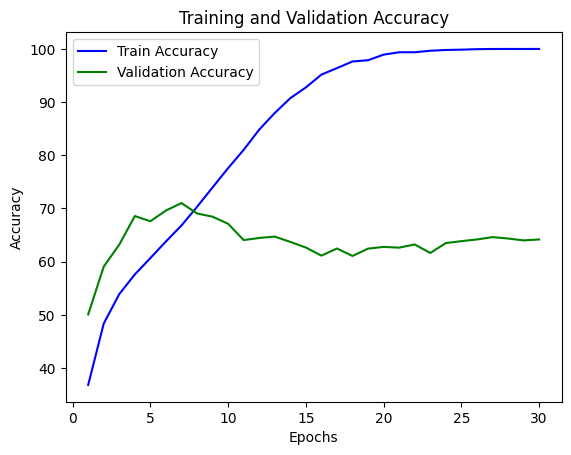

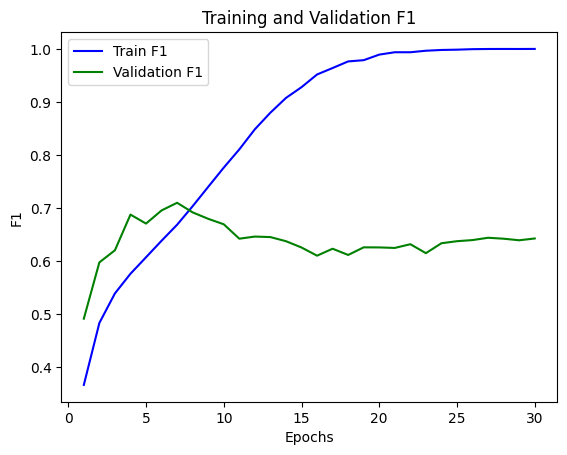

In [66]:
# 5. visualization
graph(loss_list_var2, val_loss_list_var2, "Loss", NUM_EPOCHS)
graph(acc_list_var2, val_acc_list_var2, "Accuracy", NUM_EPOCHS)
graph(f1_list_var2, val_f1_list_var2, "F1", NUM_EPOCHS)

In [67]:
# 6. find min loss
min_idx_var2 = choose_best_val(val_loss_list_var2)
print("Best model at epoch", min_idx_var2+1)

Min Val: 0.9472745838044565
Best model at epoch 6


In [68]:
# 7. test with best model w/ min loss
best_model_var2 = models.resnet18(weights=None, num_classes=10)
best_model_var2.to(DEVICE)
best_model_var2.load_state_dict(torch.load(f'./model/2-2_var2/epoch{min_idx_var2+1}.pth'))
torch.save(best_model_var2.state_dict(), f'./model/best_models/2-2_epoch{min_idx_var2+1}.pth') # save best model

test_acc_var2, test_loss_var2, test_f1_var2 = eval(best_model_var2, test_loader=test_loader_baseline, criterion=criterion)

    loss: 0.948 acc: 70.21% f1: 0.70


### 2.3. Input Perturbation
같은 라벨을 사용하되 입력 이미지에 강한 변화를 주어보자 (e.g., crop, blur 등)

#### 2.3.1. RandomResizedCrop

##### 1) Data

In [69]:
# 1. prepare new CIFAR10 train data(perturbation)
# transform
transform_var3 = transforms.Compose([
    transforms.RandomResizedCrop((20, 20)), # crop
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # well-known values
])

var3_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_var3)
    
# split
g = torch.Generator().manual_seed(seed) # seed 고정
train_size = int(0.9 * len(var3_trainset))
val_size = len(var3_trainset) - train_size
trainset_var3, _ = random_split(var3_trainset, [train_size, val_size], generator=g) # 앞선 세팅과 같은 시드를 썼으므로 같은 기준으로 split

# loader
train_loader_var3 = torch.utils.data.DataLoader(trainset_var3, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

Files already downloaded and verified


In [70]:
# 같은 기준으로 나뉘었는지 확인
for i in range(len(trainset_baseline)):
    if trainset_baseline[i][1] != trainset_var3[i][1]:
        print("Something wrong!")
else:
    print("All same.")

All same.


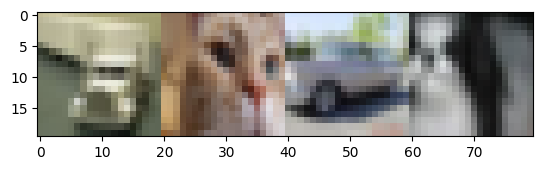

Class labels:  truck cat   car   dog  


In [71]:
dataiter = iter(train_loader_var3)
images, labels = next(dataiter)

img_grid = imshow(utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

##### 2) Model and Train

In [72]:
# 2. resnet18
model_var3 = models.resnet18(weights=None, num_classes=10) # 10 classes
model_var3.to(DEVICE)

# 3. select loss function, optimizer, and lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_var3.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=NUM_EPOCHS,
    eta_min=1e-6,
)

In [73]:
# 4. train
loss_list_var3, acc_list_var3, f1_list_var3, val_loss_list_var3, val_acc_list_var3, val_f1_list_var3 = train(model_var3, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, train_loader=train_loader_var3, val_loader=val_loader_baseline, to_save='2-3_var3')

704it [00:23, 30.43it/s]


[1] loss: 1.817 acc: 33.58% f1: 0.33
    learning rate was 0.00100
>> Validation
    loss: 2.236 acc: 20.86% f1: 0.16


704it [00:35, 19.58it/s]


[2] loss: 1.620 acc: 41.64% f1: 0.41
    learning rate was 0.00099
>> Validation
    loss: 2.085 acc: 28.38% f1: 0.24


704it [00:36, 19.27it/s]


[3] loss: 1.532 acc: 45.11% f1: 0.45
    learning rate was 0.00098
>> Validation
    loss: 1.964 acc: 31.64% f1: 0.26


704it [00:37, 18.60it/s]


[4] loss: 1.446 acc: 48.60% f1: 0.49
    learning rate was 0.00096
>> Validation
    loss: 2.130 acc: 28.02% f1: 0.26


704it [00:38, 18.06it/s]


[5] loss: 1.390 acc: 50.72% f1: 0.51
    learning rate was 0.00093
>> Validation
    loss: 1.790 acc: 35.58% f1: 0.34


704it [00:38, 18.26it/s]


[6] loss: 1.336 acc: 52.72% f1: 0.53
    learning rate was 0.00090
>> Validation
    loss: 1.994 acc: 32.66% f1: 0.29


704it [00:36, 19.25it/s]


[7] loss: 1.292 acc: 54.20% f1: 0.54
    learning rate was 0.00087
>> Validation
    loss: 1.732 acc: 41.14% f1: 0.39


704it [00:38, 18.17it/s]


[8] loss: 1.259 acc: 55.58% f1: 0.56
    learning rate was 0.00083
>> Validation
    loss: 1.889 acc: 37.08% f1: 0.34


704it [00:38, 18.29it/s]


[9] loss: 1.222 acc: 56.85% f1: 0.57
    learning rate was 0.00079
>> Validation
    loss: 1.865 acc: 36.10% f1: 0.34


704it [00:37, 18.59it/s]


[10] loss: 1.185 acc: 58.33% f1: 0.58
    learning rate was 0.00075
>> Validation
    loss: 1.667 acc: 43.48% f1: 0.42


704it [00:37, 18.83it/s]


[11] loss: 1.158 acc: 59.27% f1: 0.59
    learning rate was 0.00070
>> Validation
    loss: 1.676 acc: 43.06% f1: 0.42


704it [00:36, 19.41it/s]


[12] loss: 1.126 acc: 60.49% f1: 0.60
    learning rate was 0.00065
>> Validation
    loss: 1.818 acc: 40.32% f1: 0.38


704it [00:39, 17.84it/s]


[13] loss: 1.104 acc: 61.31% f1: 0.61
    learning rate was 0.00060
>> Validation
    loss: 1.702 acc: 43.26% f1: 0.42


704it [00:41, 17.13it/s]


[14] loss: 1.076 acc: 62.39% f1: 0.62
    learning rate was 0.00055
>> Validation
    loss: 1.594 acc: 46.76% f1: 0.46


704it [00:40, 17.20it/s]


[15] loss: 1.046 acc: 63.34% f1: 0.63
    learning rate was 0.00050
>> Validation
    loss: 1.690 acc: 44.06% f1: 0.43


704it [00:39, 17.93it/s]


[16] loss: 1.028 acc: 63.86% f1: 0.64
    learning rate was 0.00045
>> Validation
    loss: 1.653 acc: 46.58% f1: 0.45


704it [00:40, 17.29it/s]


[17] loss: 1.008 acc: 64.66% f1: 0.65
    learning rate was 0.00040
>> Validation
    loss: 1.778 acc: 43.82% f1: 0.42


704it [00:41, 16.98it/s]


[18] loss: 0.986 acc: 65.75% f1: 0.66
    learning rate was 0.00035
>> Validation
    loss: 1.632 acc: 47.66% f1: 0.47


704it [00:42, 16.74it/s]


[19] loss: 0.970 acc: 66.00% f1: 0.66
    learning rate was 0.00030
>> Validation
    loss: 1.643 acc: 46.80% f1: 0.46


704it [00:42, 16.48it/s]


[20] loss: 0.940 acc: 67.00% f1: 0.67
    learning rate was 0.00025
>> Validation
    loss: 1.695 acc: 49.28% f1: 0.48


704it [00:41, 16.81it/s]


[21] loss: 0.928 acc: 67.58% f1: 0.68
    learning rate was 0.00021
>> Validation
    loss: 1.550 acc: 50.66% f1: 0.50


704it [00:40, 17.57it/s]


[22] loss: 0.901 acc: 68.47% f1: 0.68
    learning rate was 0.00017
>> Validation
    loss: 1.577 acc: 49.82% f1: 0.49


704it [00:37, 18.90it/s]


[23] loss: 0.897 acc: 68.37% f1: 0.68
    learning rate was 0.00013
>> Validation
    loss: 1.605 acc: 49.12% f1: 0.48


704it [00:40, 17.24it/s]


[24] loss: 0.882 acc: 69.23% f1: 0.69
    learning rate was 0.00010
>> Validation
    loss: 1.577 acc: 50.58% f1: 0.50


704it [00:39, 17.63it/s]


[25] loss: 0.869 acc: 69.69% f1: 0.70
    learning rate was 0.00007
>> Validation
    loss: 1.583 acc: 49.86% f1: 0.49


704it [00:40, 17.51it/s]


[26] loss: 0.862 acc: 69.91% f1: 0.70
    learning rate was 0.00004
>> Validation
    loss: 1.567 acc: 50.98% f1: 0.50


704it [00:38, 18.39it/s]


[27] loss: 0.847 acc: 70.25% f1: 0.70
    learning rate was 0.00003
>> Validation
    loss: 1.635 acc: 49.86% f1: 0.49


704it [00:38, 18.50it/s]


[28] loss: 0.841 acc: 70.55% f1: 0.71
    learning rate was 0.00001
>> Validation
    loss: 1.612 acc: 50.60% f1: 0.50


704it [00:42, 16.74it/s]


[29] loss: 0.839 acc: 70.61% f1: 0.71
    learning rate was 0.00000
>> Validation
    loss: 1.572 acc: 50.60% f1: 0.50


704it [00:40, 17.46it/s]


[30] loss: 0.846 acc: 70.31% f1: 0.70
    learning rate was 0.00000
>> Validation
    loss: 1.551 acc: 50.80% f1: 0.50
Finished Training


##### 3) Test and Visualization

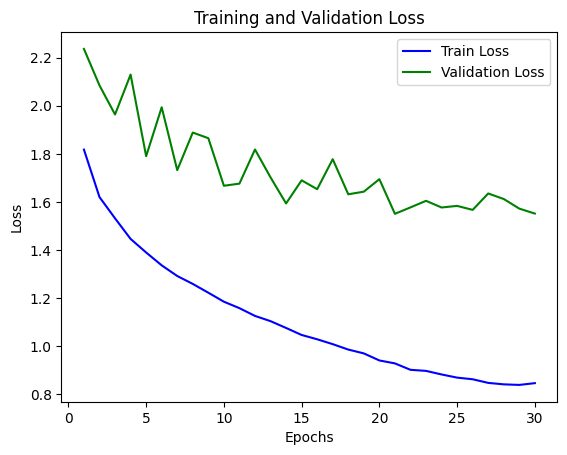

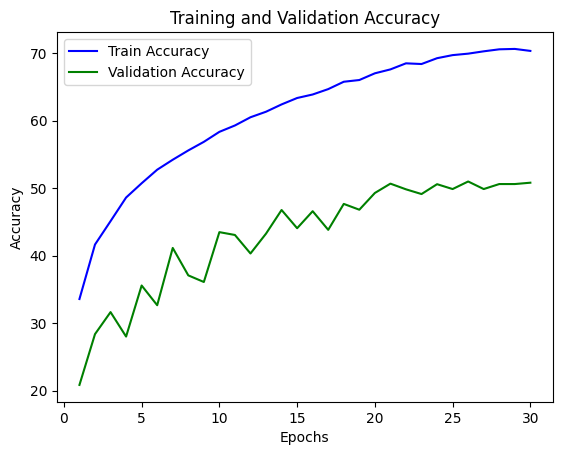

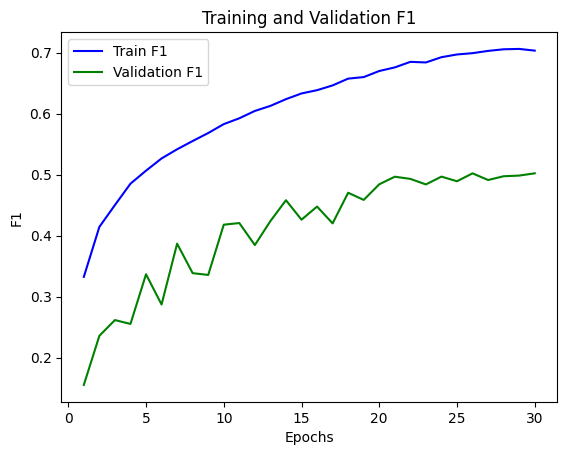

In [74]:
# 수렴이 느리다는 관찰
# 5. visualization
graph(loss_list_var3, val_loss_list_var3, "Loss", NUM_EPOCHS)
graph(acc_list_var3, val_acc_list_var3, "Accuracy", NUM_EPOCHS)
graph(f1_list_var3, val_f1_list_var3, "F1", NUM_EPOCHS)

In [75]:
# 6. find min loss
min_idx_var3 = choose_best_val(val_loss_list_var3)
print("Best model at epoch", min_idx_var3+1)

# 7. test with best model w/ min loss
best_model_var3 = models.resnet18(weights=None, num_classes=10)
best_model_var3.to(DEVICE)
best_model_var3.load_state_dict(torch.load(f'./model/2-3_var3/epoch{min_idx_var3+1}.pth'))
torch.save(best_model_var3.state_dict(), f'./model/best_models/2-3-1_epoch{min_idx_var3+1}.pth') # save best model

test_acc_var3, test_loss_var3, test_f1_var3 = eval(best_model_var3, test_loader=test_loader_baseline, criterion=criterion)


Min Val: 1.550392608099346
Best model at epoch 21
    loss: 1.531 acc: 50.36% f1: 0.50


#### 2.3.2. Blur

##### 1) Data

In [76]:
# 1. prepare new CIFAR10 train data(perturbation)
# transform
transform_var3_1 = transforms.Compose([
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1.0, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # well-known values
])

var3_1_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_var3_1)
    
# split
g = torch.Generator().manual_seed(seed) # seed 고정
train_size = int(0.9 * len(var3_1_trainset))
val_size = len(var3_1_trainset) - train_size
trainset_var3_1, _ = random_split(var3_1_trainset, [train_size, val_size], generator=g)

# loader
train_loader_var3_1 = torch.utils.data.DataLoader(trainset_var3_1, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# 같은 기준으로 나뉘었는지 확인
for i in range(len(trainset_baseline)):
    if trainset_baseline[i][1] != trainset_var3_1[i][1]:
        print("Something wrong!")
else:
    print("All same.")

Files already downloaded and verified
All same.


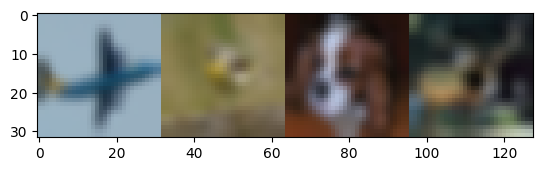

Class labels:  plane bird  dog   deer 


In [77]:
dataiter = iter(train_loader_var3_1)
images, labels = next(dataiter)

img_grid = imshow(utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

##### 2) Model and Train

In [78]:
# 2. resnet18
model_var3_1 = models.resnet18(weights=None, num_classes=10) # 10 classes
model_var3_1.to(DEVICE)

# 3. select loss function, optimizer, and lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_var3_1.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=NUM_EPOCHS,
    eta_min=1e-6,
)

In [79]:
# 4. train
loss_list_var3_1, acc_list_var3_1, f1_list_var3_1, val_loss_list_var3_1, val_acc_list_var3_1, val_f1_list_var3_1 = train(model_var3_1, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, train_loader=train_loader_var3_1, val_loader=val_loader_baseline, to_save='2-3_1_var3_1')

704it [00:33, 21.09it/s]


[1] loss: 1.537 acc: 44.86% f1: 0.45
    learning rate was 0.00100
>> Validation
    loss: 1.494 acc: 48.60% f1: 0.47


704it [00:55, 12.71it/s]


[2] loss: 1.202 acc: 57.34% f1: 0.57
    learning rate was 0.00099
>> Validation
    loss: 1.304 acc: 54.48% f1: 0.52


704it [00:59, 11.90it/s]


[3] loss: 1.035 acc: 63.67% f1: 0.64
    learning rate was 0.00098
>> Validation
    loss: 1.169 acc: 60.24% f1: 0.59


704it [01:05, 10.80it/s]


[4] loss: 0.901 acc: 68.50% f1: 0.68
    learning rate was 0.00096
>> Validation
    loss: 1.025 acc: 63.68% f1: 0.63


704it [01:04, 10.92it/s]


[5] loss: 0.793 acc: 72.43% f1: 0.72
    learning rate was 0.00093
>> Validation
    loss: 0.993 acc: 65.68% f1: 0.65


704it [01:04, 10.96it/s]


[6] loss: 0.702 acc: 75.54% f1: 0.76
    learning rate was 0.00090
>> Validation
    loss: 1.024 acc: 65.46% f1: 0.65


704it [01:04, 10.94it/s]


[7] loss: 0.590 acc: 79.38% f1: 0.79
    learning rate was 0.00087
>> Validation
    loss: 1.020 acc: 67.38% f1: 0.67


704it [01:01, 11.42it/s]


[8] loss: 0.490 acc: 82.78% f1: 0.83
    learning rate was 0.00083
>> Validation
    loss: 1.116 acc: 66.98% f1: 0.66


704it [00:59, 11.75it/s]


[9] loss: 0.389 acc: 86.47% f1: 0.86
    learning rate was 0.00079
>> Validation
    loss: 1.194 acc: 66.82% f1: 0.66


704it [00:56, 12.37it/s]


[10] loss: 0.299 acc: 89.36% f1: 0.89
    learning rate was 0.00075
>> Validation
    loss: 1.342 acc: 65.60% f1: 0.65


704it [00:56, 12.38it/s]


[11] loss: 0.240 acc: 91.51% f1: 0.92
    learning rate was 0.00070
>> Validation
    loss: 1.433 acc: 66.30% f1: 0.66


704it [00:55, 12.70it/s]


[12] loss: 0.175 acc: 93.93% f1: 0.94
    learning rate was 0.00065
>> Validation
    loss: 1.540 acc: 67.02% f1: 0.67


704it [00:56, 12.39it/s]


[13] loss: 0.136 acc: 95.50% f1: 0.96
    learning rate was 0.00060
>> Validation
    loss: 1.609 acc: 68.28% f1: 0.68


704it [00:56, 12.47it/s]


[14] loss: 0.116 acc: 95.94% f1: 0.96
    learning rate was 0.00055
>> Validation
    loss: 1.710 acc: 67.52% f1: 0.67


704it [01:01, 11.48it/s]


[15] loss: 0.083 acc: 97.06% f1: 0.97
    learning rate was 0.00050
>> Validation
    loss: 1.685 acc: 68.14% f1: 0.68


704it [01:02, 11.19it/s]


[16] loss: 0.060 acc: 97.93% f1: 0.98
    learning rate was 0.00045
>> Validation
    loss: 1.873 acc: 67.96% f1: 0.68


704it [01:02, 11.28it/s]


[17] loss: 0.053 acc: 98.16% f1: 0.98
    learning rate was 0.00040
>> Validation
    loss: 1.841 acc: 69.02% f1: 0.69


704it [01:02, 11.21it/s]


[18] loss: 0.034 acc: 98.89% f1: 0.99
    learning rate was 0.00035
>> Validation
    loss: 1.976 acc: 68.48% f1: 0.68


704it [01:02, 11.22it/s]


[19] loss: 0.037 acc: 98.76% f1: 0.99
    learning rate was 0.00030
>> Validation
    loss: 2.029 acc: 68.76% f1: 0.68


704it [01:04, 10.98it/s]


[20] loss: 0.025 acc: 99.25% f1: 0.99
    learning rate was 0.00025
>> Validation
    loss: 2.079 acc: 69.18% f1: 0.69


704it [01:01, 11.49it/s]


[21] loss: 0.018 acc: 99.41% f1: 0.99
    learning rate was 0.00021
>> Validation
    loss: 2.052 acc: 69.10% f1: 0.69


704it [01:04, 10.91it/s]


[22] loss: 0.011 acc: 99.66% f1: 1.00
    learning rate was 0.00017
>> Validation
    loss: 2.095 acc: 69.42% f1: 0.69


704it [00:58, 12.13it/s]


[23] loss: 0.005 acc: 99.86% f1: 1.00
    learning rate was 0.00013
>> Validation
    loss: 2.201 acc: 68.80% f1: 0.68


704it [00:58, 12.06it/s]


[24] loss: 0.004 acc: 99.92% f1: 1.00
    learning rate was 0.00010
>> Validation
    loss: 2.161 acc: 69.46% f1: 0.69


704it [00:59, 11.90it/s]


[25] loss: 0.006 acc: 99.88% f1: 1.00
    learning rate was 0.00007
>> Validation
    loss: 2.210 acc: 69.80% f1: 0.69


704it [00:59, 11.92it/s]


[26] loss: 0.004 acc: 99.88% f1: 1.00
    learning rate was 0.00004
>> Validation
    loss: 2.259 acc: 69.14% f1: 0.69


704it [01:04, 10.89it/s]


[27] loss: 0.002 acc: 99.96% f1: 1.00
    learning rate was 0.00003
>> Validation
    loss: 2.225 acc: 69.22% f1: 0.69


704it [01:00, 11.70it/s]


[28] loss: 0.001 acc: 99.98% f1: 1.00
    learning rate was 0.00001
>> Validation
    loss: 2.175 acc: 69.34% f1: 0.69


704it [00:57, 12.14it/s]


[29] loss: 0.001 acc: 99.97% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 2.220 acc: 69.18% f1: 0.69


704it [00:58, 12.04it/s]


[30] loss: 0.001 acc: 99.98% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 2.281 acc: 69.24% f1: 0.69
Finished Training


##### 3) Test and Visualization

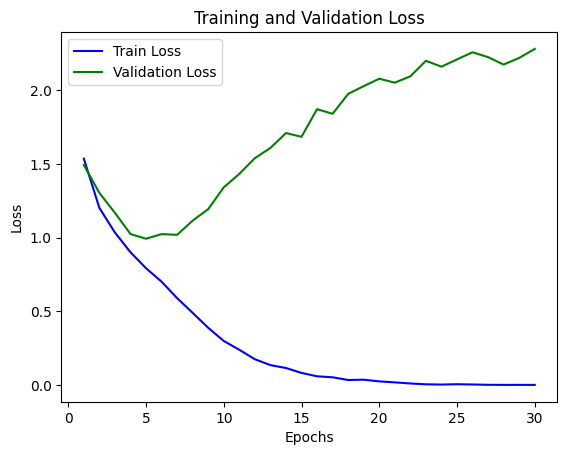

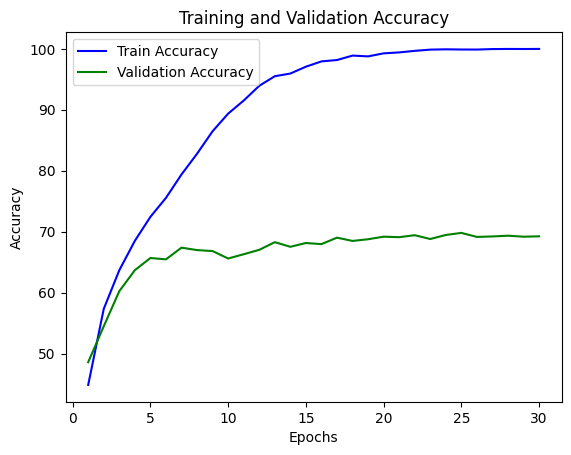

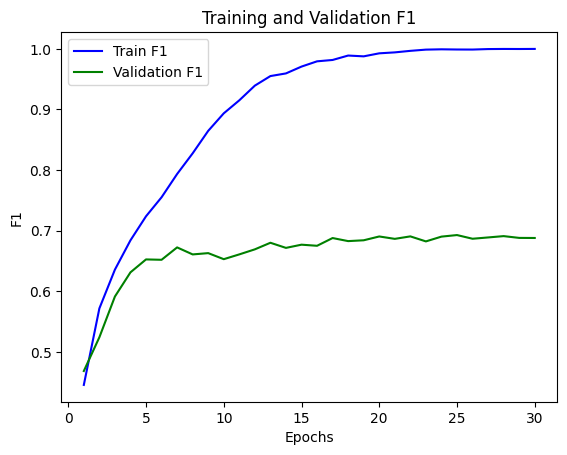

In [80]:
# 5. visualization
graph(loss_list_var3_1, val_loss_list_var3_1, "Loss", NUM_EPOCHS)
graph(acc_list_var3_1, val_acc_list_var3_1, "Accuracy", NUM_EPOCHS)
graph(f1_list_var3_1, val_f1_list_var3_1, "F1", NUM_EPOCHS)

In [81]:
# 6. find min loss
min_idx_var3_1 = choose_best_val(val_loss_list_var3_1)
print("Best model at epoch", min_idx_var3_1+1)

# 7. test with best model w/ min loss
best_model_var3_1 = models.resnet18(weights=None, num_classes=10)
best_model_var3_1.to(DEVICE)
best_model_var3_1.load_state_dict(torch.load(f'./model/2-3_1_var3_1/epoch{min_idx_var3_1+1}.pth'))
torch.save(best_model_var3_1.state_dict(), f'./model/best_models/2-3-2_epoch{min_idx_var3_1+1}.pth') # save best model

test_acc_var3_1, test_loss_var3_1, test_f1_var3_1 = eval(best_model_var3_1, test_loader=test_loader_baseline, criterion=criterion)

Min Val: 1.0244244699236713
Best model at epoch 6
    loss: 1.036 acc: 65.91% f1: 0.66


### 2.4. Class Imbalance (클래스 불균형)
일부 클래스의 샘플 수를 극단적으로 줄여서 학습

#### 1) Data

In [82]:
# 1. prepare new CIFAR10 train data (class imbalance)
trainset_var4 = copy.deepcopy(trainset_baseline)

# 클래스별 인덱스 수집
class_indices = defaultdict(list)
for idx, (data, label) in enumerate(trainset_var4):
    class_indices[label].append(idx)

# 불균형하게 만들기: 0~4는 전부 사용, 5~9는 10%만 사용
selected_indices = []
for cls, indices in class_indices.items():
    if cls < 5:
        selected_indices.extend(indices)
    else:
        n_select = int(len(indices) * 0.1)
        selected_indices.extend(random.sample(indices, n_select))

# Subset으로 변환
var4_trainset = Subset(trainset_var4, selected_indices)

# 원래 분포 확인
labels = [trainset_var4[i][1] for i in range(len(trainset_var4))]
print("Original:", Counter(labels))

# 바뀐 분포 확인
labels = [var4_trainset[i][1] for i in range(len(var4_trainset))]
print("Changed:", Counter(labels))

# loader
train_loader_var4 = torch.utils.data.DataLoader(var4_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)


Original: Counter({4: 4529, 3: 4529, 0: 4512, 7: 4500, 9: 4499, 8: 4496, 6: 4493, 1: 4488, 5: 4486, 2: 4468})
Changed: Counter({4: 4529, 3: 4529, 0: 4512, 1: 4488, 2: 4468, 7: 450, 6: 449, 8: 449, 9: 449, 5: 448})


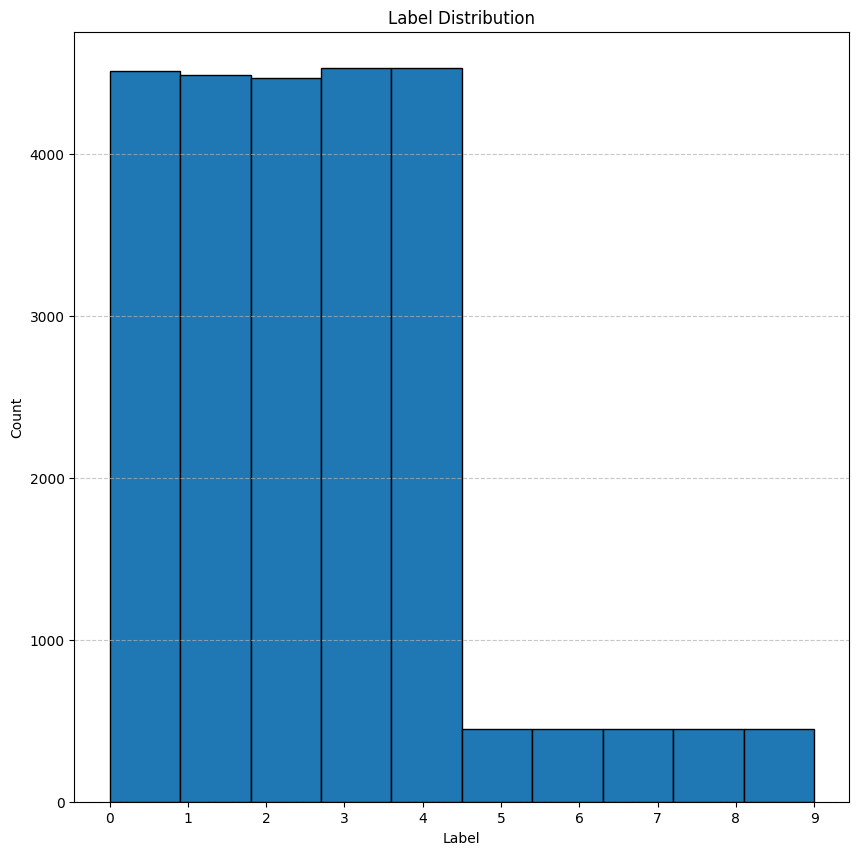

In [83]:
# 히스토그램 그리기
plt.figure(figsize=(10, 10))
plt.hist(labels, bins=len(set(labels)), edgecolor='black')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(sorted(set(labels)))  # 정렬된 라벨 값 표시
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 2) Model and Train

In [84]:
# 2. resnet18
model_var4 = models.resnet18(weights=None, num_classes=10) # 10 classes
model_var4.to(DEVICE)

# 3. select loss function, optimizer, and lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_var4.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=NUM_EPOCHS,
    eta_min=1e-6,
)

In [85]:
# 4. train
loss_list_var4, acc_list_var4, f1_list_var4, val_loss_list_var4, val_acc_list_var4, val_f1_list_var4 = train(model_var4, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, train_loader=train_loader_var4, val_loader=val_loader_baseline, to_save='2-4_var4')

388it [00:14, 27.42it/s]


[1] loss: 1.296 acc: 55.26% f1: 0.31
    learning rate was 0.00100
>> Validation
    loss: 2.197 acc: 31.06% f1: 0.24


388it [00:11, 33.37it/s]


[2] loss: 1.047 acc: 63.82% f1: 0.41
    learning rate was 0.00099
>> Validation
    loss: 1.848 acc: 41.04% f1: 0.33


388it [00:11, 32.69it/s]


[3] loss: 0.862 acc: 70.49% f1: 0.52
    learning rate was 0.00098
>> Validation
    loss: 1.735 acc: 44.48% f1: 0.40


388it [00:11, 33.79it/s]


[4] loss: 0.741 acc: 74.72% f1: 0.59
    learning rate was 0.00096
>> Validation
    loss: 1.537 acc: 51.46% f1: 0.48


388it [00:14, 26.48it/s]


[5] loss: 0.655 acc: 77.82% f1: 0.64
    learning rate was 0.00093
>> Validation
    loss: 1.636 acc: 52.50% f1: 0.48


388it [00:17, 21.84it/s]


[6] loss: 0.531 acc: 82.03% f1: 0.71
    learning rate was 0.00090
>> Validation
    loss: 1.454 acc: 56.50% f1: 0.55


388it [00:17, 21.93it/s]


[7] loss: 0.472 acc: 83.88% f1: 0.75
    learning rate was 0.00087
>> Validation
    loss: 1.420 acc: 58.74% f1: 0.58


388it [00:17, 21.76it/s]


[8] loss: 0.361 acc: 87.82% f1: 0.81
    learning rate was 0.00083
>> Validation
    loss: 1.650 acc: 57.36% f1: 0.55


388it [00:17, 22.11it/s]


[9] loss: 0.292 acc: 90.02% f1: 0.85
    learning rate was 0.00079
>> Validation
    loss: 1.726 acc: 58.12% f1: 0.57


388it [00:17, 22.77it/s]


[10] loss: 0.239 acc: 92.12% f1: 0.88
    learning rate was 0.00075
>> Validation
    loss: 1.704 acc: 59.56% f1: 0.59


388it [00:17, 22.48it/s]


[11] loss: 0.190 acc: 93.59% f1: 0.91
    learning rate was 0.00070
>> Validation
    loss: 2.072 acc: 56.52% f1: 0.55


388it [00:17, 22.51it/s]


[12] loss: 0.114 acc: 96.11% f1: 0.94
    learning rate was 0.00065
>> Validation
    loss: 2.110 acc: 59.90% f1: 0.59


388it [00:17, 21.85it/s]


[13] loss: 0.128 acc: 95.70% f1: 0.94
    learning rate was 0.00060
>> Validation
    loss: 2.298 acc: 58.46% f1: 0.57


388it [00:17, 22.62it/s]


[14] loss: 0.117 acc: 96.17% f1: 0.95
    learning rate was 0.00055
>> Validation
    loss: 2.453 acc: 58.00% f1: 0.56


388it [00:17, 22.57it/s]


[15] loss: 0.065 acc: 97.90% f1: 0.97
    learning rate was 0.00050
>> Validation
    loss: 2.485 acc: 59.10% f1: 0.57


388it [00:17, 22.65it/s]


[16] loss: 0.024 acc: 99.23% f1: 0.99
    learning rate was 0.00045
>> Validation
    loss: 2.512 acc: 60.40% f1: 0.59


388it [00:17, 22.50it/s]


[17] loss: 0.024 acc: 99.25% f1: 0.99
    learning rate was 0.00040
>> Validation
    loss: 2.899 acc: 58.32% f1: 0.57


388it [00:17, 21.75it/s]


[18] loss: 0.023 acc: 99.25% f1: 0.99
    learning rate was 0.00035
>> Validation
    loss: 2.809 acc: 59.60% f1: 0.58


388it [00:17, 22.46it/s]


[19] loss: 0.023 acc: 99.39% f1: 0.99
    learning rate was 0.00030
>> Validation
    loss: 2.881 acc: 58.98% f1: 0.58


388it [00:17, 22.00it/s]


[20] loss: 0.032 acc: 99.12% f1: 0.99
    learning rate was 0.00025
>> Validation
    loss: 2.853 acc: 59.00% f1: 0.57


388it [00:17, 21.88it/s]


[21] loss: 0.018 acc: 99.42% f1: 0.99
    learning rate was 0.00021
>> Validation
    loss: 2.830 acc: 60.16% f1: 0.59


388it [00:17, 22.25it/s]


[22] loss: 0.015 acc: 99.51% f1: 0.99
    learning rate was 0.00017
>> Validation
    loss: 2.958 acc: 59.84% f1: 0.59


388it [00:17, 22.29it/s]


[23] loss: 0.005 acc: 99.92% f1: 1.00
    learning rate was 0.00013
>> Validation
    loss: 3.027 acc: 59.76% f1: 0.58


388it [00:18, 21.13it/s]


[24] loss: 0.016 acc: 99.83% f1: 1.00
    learning rate was 0.00010
>> Validation
    loss: 3.118 acc: 59.44% f1: 0.58


388it [00:17, 22.15it/s]


[25] loss: 0.025 acc: 99.75% f1: 1.00
    learning rate was 0.00007
>> Validation
    loss: 3.080 acc: 59.54% f1: 0.58


388it [00:17, 21.82it/s]


[26] loss: 0.015 acc: 99.78% f1: 1.00
    learning rate was 0.00004
>> Validation
    loss: 3.134 acc: 59.32% f1: 0.58


388it [00:17, 22.32it/s]


[27] loss: 0.007 acc: 99.95% f1: 1.00
    learning rate was 0.00003
>> Validation
    loss: 3.167 acc: 59.24% f1: 0.58


388it [00:17, 22.03it/s]


[28] loss: 0.007 acc: 99.93% f1: 1.00
    learning rate was 0.00001
>> Validation
    loss: 3.182 acc: 59.78% f1: 0.59


388it [00:16, 22.99it/s]


[29] loss: 0.003 acc: 99.97% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 3.101 acc: 59.84% f1: 0.59


388it [00:17, 21.64it/s]


[30] loss: 0.002 acc: 99.97% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 3.038 acc: 60.22% f1: 0.59
Finished Training


#### 3) Test and Visualization

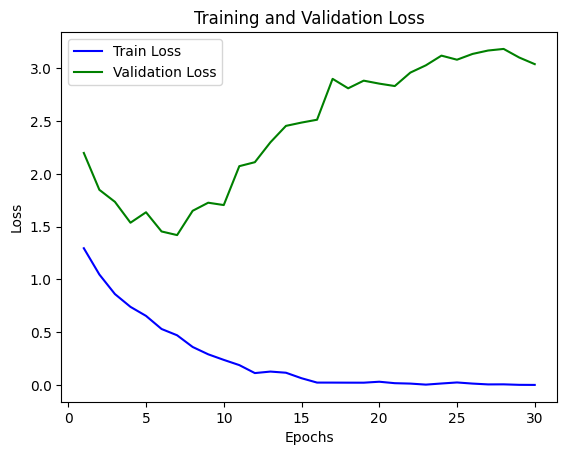

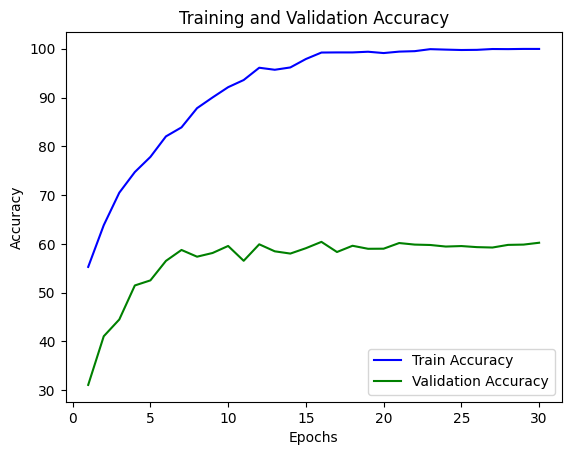

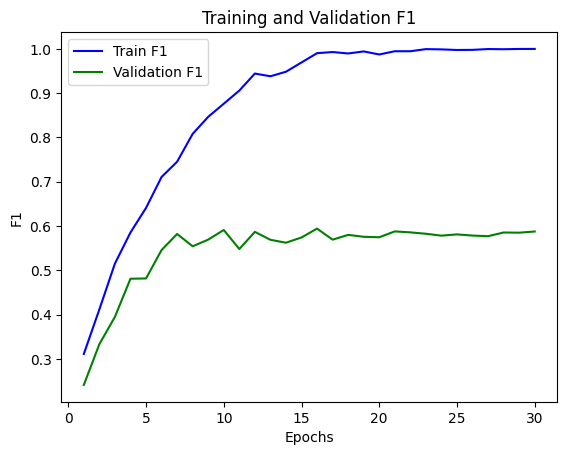

In [86]:
# 5. visualization
graph(loss_list_var4, val_loss_list_var4, "Loss", NUM_EPOCHS)
graph(acc_list_var4, val_acc_list_var4, "Accuracy", NUM_EPOCHS)
graph(f1_list_var4, val_f1_list_var4, "F1", NUM_EPOCHS)

In [87]:
# 6. find min loss
min_idx_var4 = choose_best_val(val_loss_list_var4)
print("Best model at epoch", min_idx_var4+1)

# 7. test with best model w/ min loss
best_model_var4 = models.resnet18(weights=None, num_classes=10)
best_model_var4.to(DEVICE)
best_model_var4.load_state_dict(torch.load(f'./model/2-4_var4/epoch{min_idx_var4+1}.pth'))
torch.save(best_model_var4.state_dict(), f'./model/best_models/2-4_epoch{min_idx_var4+1}.pth') # save best model

test_acc_var4, test_loss_var4, test_f1_var4 = eval(best_model_var4, test_loader=test_loader_baseline, criterion=criterion)

Min Val: 1.4542620664910426
Best model at epoch 6
    loss: 1.423 acc: 57.09% f1: 0.55


# 3. Comparison

**best model for each setting**

1. Baseline: epoch 6
2. Variants
    
    2.1. Random Label Shuffle: epoch 24

    2.2. Label Noise: epoch 6

    2.3.1. Input Perturbation-crop&flip: epoch 21

    2.3.2. Input Perturbation-blur: epoch 6

    2.4. Class Imblalance:epoch 6


In [88]:
# 1. load best models
model_dir = './model/best_models/'
model_files = sorted([f for f in os.listdir(model_dir) if f.endswith('.pth')])

loaded_models = {}

for file_name in model_files:
    model_path = os.path.join(model_dir, file_name)

    model = models.resnet18(weights=None, num_classes=10)
    model.to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    loaded_models[file_name.split('.')[0].split('_')[0]] = model
    
print(loaded_models.keys())

dict_keys(['1', '2-1', '2-2', '2-3-1', '2-3-2', '2-4'])


### 3.1. Accuracy & F1 score

In [89]:
# 2. calculate acc and f1-score
results = []

for name, model in loaded_models.items():
    acc, _, f1 = eval(model, test_loader_baseline, criterion)
    results.append({'Model': name, 'Accuracy': acc, 'F1 Score': f1})

df_results = pd.DataFrame(results)
print(df_results.round(4))


    loss: 0.798 acc: 73.77% f1: 0.74
    loss: 2.300 acc: 11.44% f1: 0.09
    loss: 0.948 acc: 70.21% f1: 0.70
    loss: 1.531 acc: 50.36% f1: 0.50
    loss: 1.036 acc: 65.91% f1: 0.66
    loss: 1.423 acc: 57.09% f1: 0.55
   Model  Accuracy  F1 Score
0      1     73.77    0.7374
1    2-1     11.44    0.0912
2    2-2     70.21    0.7021
3  2-3-1     50.36    0.4958
4  2-3-2     65.91    0.6568
5    2-4     57.09    0.5534


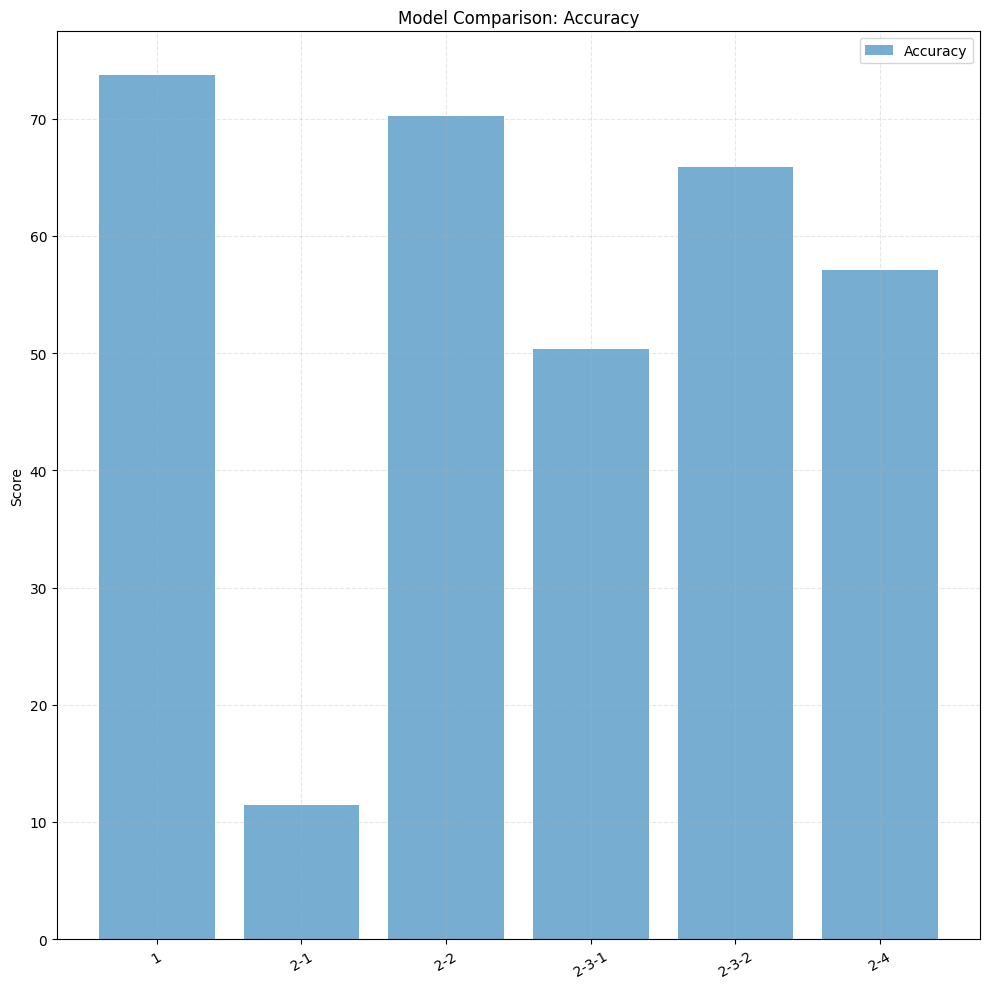

In [95]:
# 3. visualization
df_results_sorted = df_results

plt.figure(figsize=(10, 10))
plt.bar(df_results_sorted['Model'], df_results_sorted['Accuracy'], alpha=0.6, label='Accuracy')
plt.ylabel('Score')
plt.title('Model Comparison: Accuracy')
plt.xticks(rotation=30)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


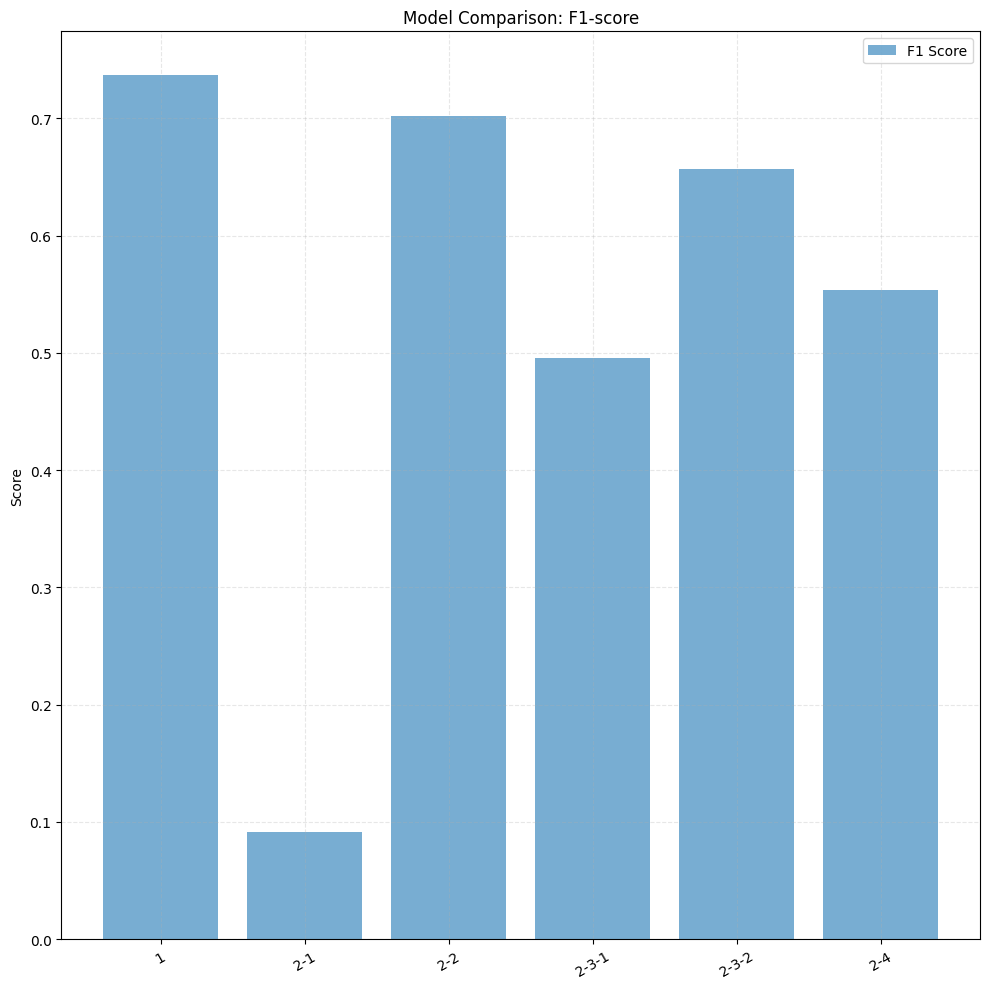

In [98]:
df_results_sorted = df_results

plt.figure(figsize=(10, 10))
plt.bar(df_results_sorted['Model'], df_results_sorted['F1 Score'], alpha=0.6, label='F1 Score')
plt.ylabel('Score')
plt.title('Model Comparison: F1-score')
plt.xticks(rotation=30)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2. Class-wise accuracy

In [91]:
# 4. get class-wise accuracy
def compute_class_accuracy(model, dataloader, device, num_classes=10):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # confusion matrix로부터 클래스별 정확도 계산
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    class_accuracy = cm.diagonal() / cm.sum(axis=1)

    return class_accuracy  # shape: (num_classes,)


In [92]:
model_class_accuracies = {}  # {모델이름: [클래스 정확도 배열]}

for name, model in loaded_models.items():
    acc = compute_class_accuracy(model, test_loader_baseline, DEVICE, num_classes=10)
    model_class_accuracies[name] = acc
    
class_names = [f'Class {i}' for i in range(10)]

df = pd.DataFrame(model_class_accuracies, index=class_names)
print(df.T.round(3))

       Class 0  Class 1  Class 2  Class 3  Class 4  Class 5  Class 6  Class 7  \
1        0.857    0.788    0.545    0.613    0.635    0.673    0.785    0.808   
2-1      0.023    0.044    0.127    0.008    0.456    0.127    0.052    0.220   
2-2      0.809    0.835    0.640    0.499    0.625    0.632    0.669    0.824   
2-3-1    0.283    0.471    0.608    0.446    0.611    0.521    0.660    0.519   
2-3-2    0.803    0.825    0.598    0.581    0.511    0.478    0.809    0.774   
2-4      0.772    0.852    0.755    0.649    0.705    0.097    0.331    0.379   

       Class 8  Class 9  
1        0.837    0.836  
2-1      0.028    0.059  
2-2      0.814    0.674  
2-3-1    0.703    0.214  
2-3-2    0.545    0.667  
2-4      0.626    0.543  


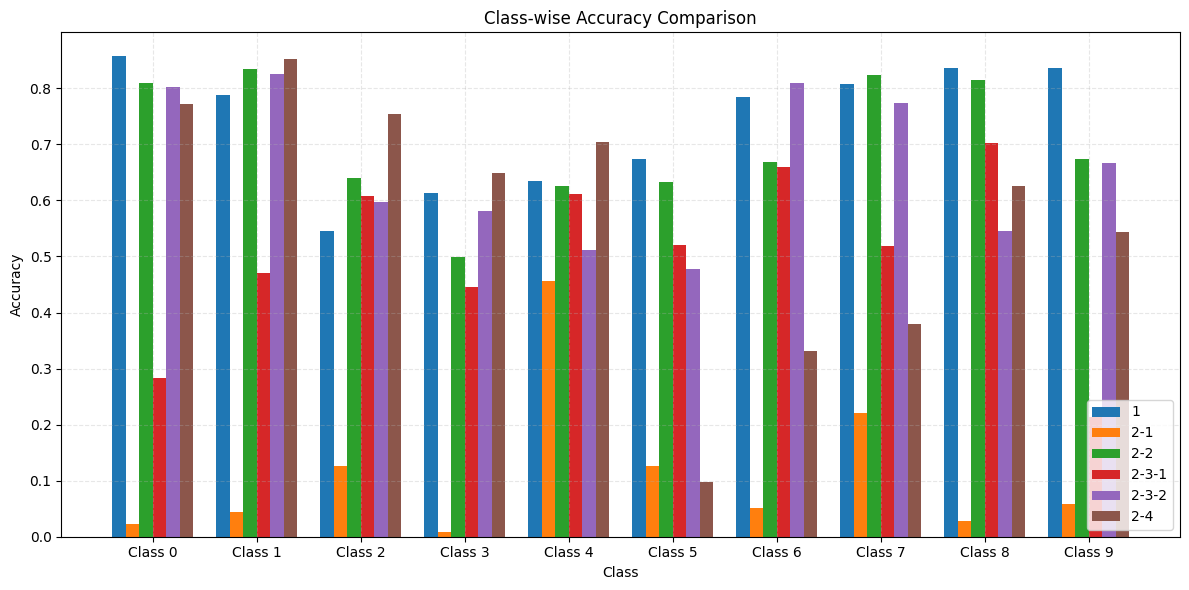

In [93]:
x = np.arange(len(class_names))
width = 0.13

fig, ax = plt.subplots(figsize=(12, 6))

for i, (name, model_acc) in enumerate(model_class_accuracies.items()):
    ax.bar(x + i * width, model_acc, width, label=name)

ax.set_xlabel('Class')
ax.set_ylabel('Accuracy')
ax.set_title('Class-wise Accuracy Comparison')
ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(class_names)
ax.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


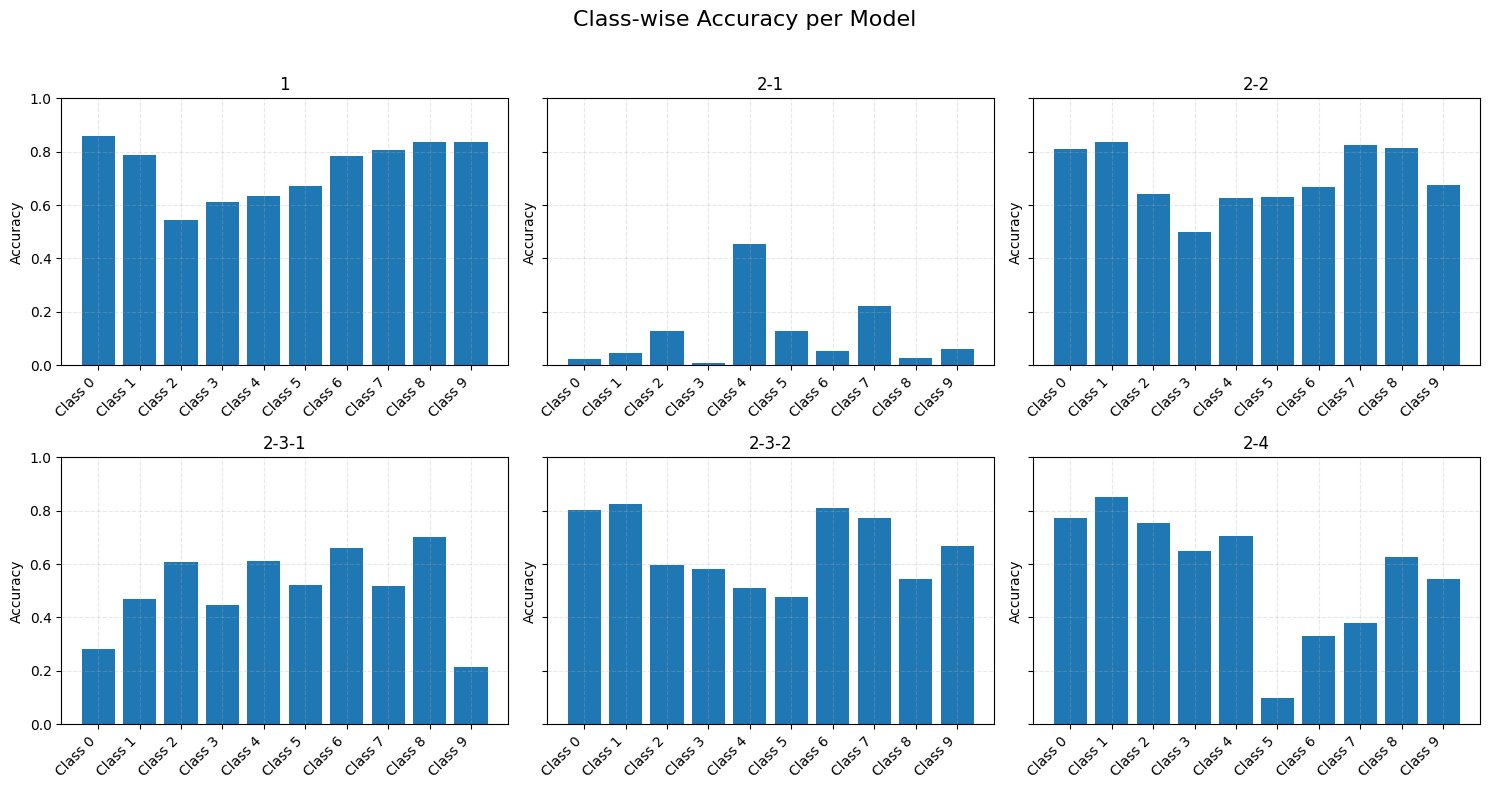

In [94]:
num_models = len(model_class_accuracies)

cols = 3
rows = (num_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), sharey=True)

axes = axes.flatten()  # 서브플롯을 1D 배열로 변환
x = np.arange(len(class_names))

for i, (model_name, class_acc) in enumerate(model_class_accuracies.items()):
    ax = axes[i]
    ax.bar(class_names, class_acc)
    ax.set_title(model_name)
    ax.set_ylim(0, 1.0)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylabel('Accuracy')
    ax.grid(True, linestyle='--', alpha=0.3)

# 남는 subplot 제거
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Class-wise Accuracy per Model", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
